<a href="https://colab.research.google.com/github/venkatesh1226/CMPE255-DataMining/blob/main/images_pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
import os
import zipfile

# Unzipping the dataset
zip_path = "/content/drive/MyDrive/DM_Assignment_05/image-dataset(pokemon)/image-dataset(pokemon).zip"
extract_folder = "/content/drive/MyDrive/DM_Assignment_05/image-dataset(pokemon)/image-dataset(pokemon)"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# List the contents of the extracted folder
contents = os.listdir(extract_folder)
contents


['images', 'pokemon.csv']

In [2]:
import pandas as pd

# Load the CSV file
csv_path = os.path.join(extract_folder, "pokemon.csv")
pokemon_df = pd.read_csv(csv_path)

# Display the first few rows of the dataframe
pokemon_df.head()


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


The CSV file contains information about Pokémon, including their names and types. Each Pokémon can have up to two types (Type1 and Type2). Some Pokémon have only one type (as indicated by NaN in the Type2 column).

## Step 2: Data Preprocessing & Cleaning

Before diving into data preprocessing, let's check for any missing values in the CSV file.​

In [3]:
# Check for missing values
missing_values = pokemon_df.isnull().sum()
missing_values


Name       0
Type1      0
Type2    404
dtype: int64

The Type2 column has 404 missing values, which means that 404 Pokémon have only one type. This is expected, as many Pokémon have only one primary type.

We can fill the missing values in the Type2 column with a placeholder like "None" to indicate the absence of a second type.

Let's proceed with that.​

In [4]:
# Fill missing values in the Type2 column with "None"
pokemon_df['Type2'].fillna('None', inplace=True)

# Check if there are any more missing values
missing_values_updated = pokemon_df.isnull().sum()
missing_values_updated


Name     0
Type1    0
Type2    0
dtype: int64

All missing values have been addressed.

## Step 3: Exploratory Data Analysis (EDA)

For the EDA, we'll:

Visualize the distribution of Pokémon based on their primary (Type1) and secondary (Type2) types.
Load and display a few images from the images folder to get a visual sense of the dataset.
Let's start by visualizing the distribution of Pokémon based on their types.​

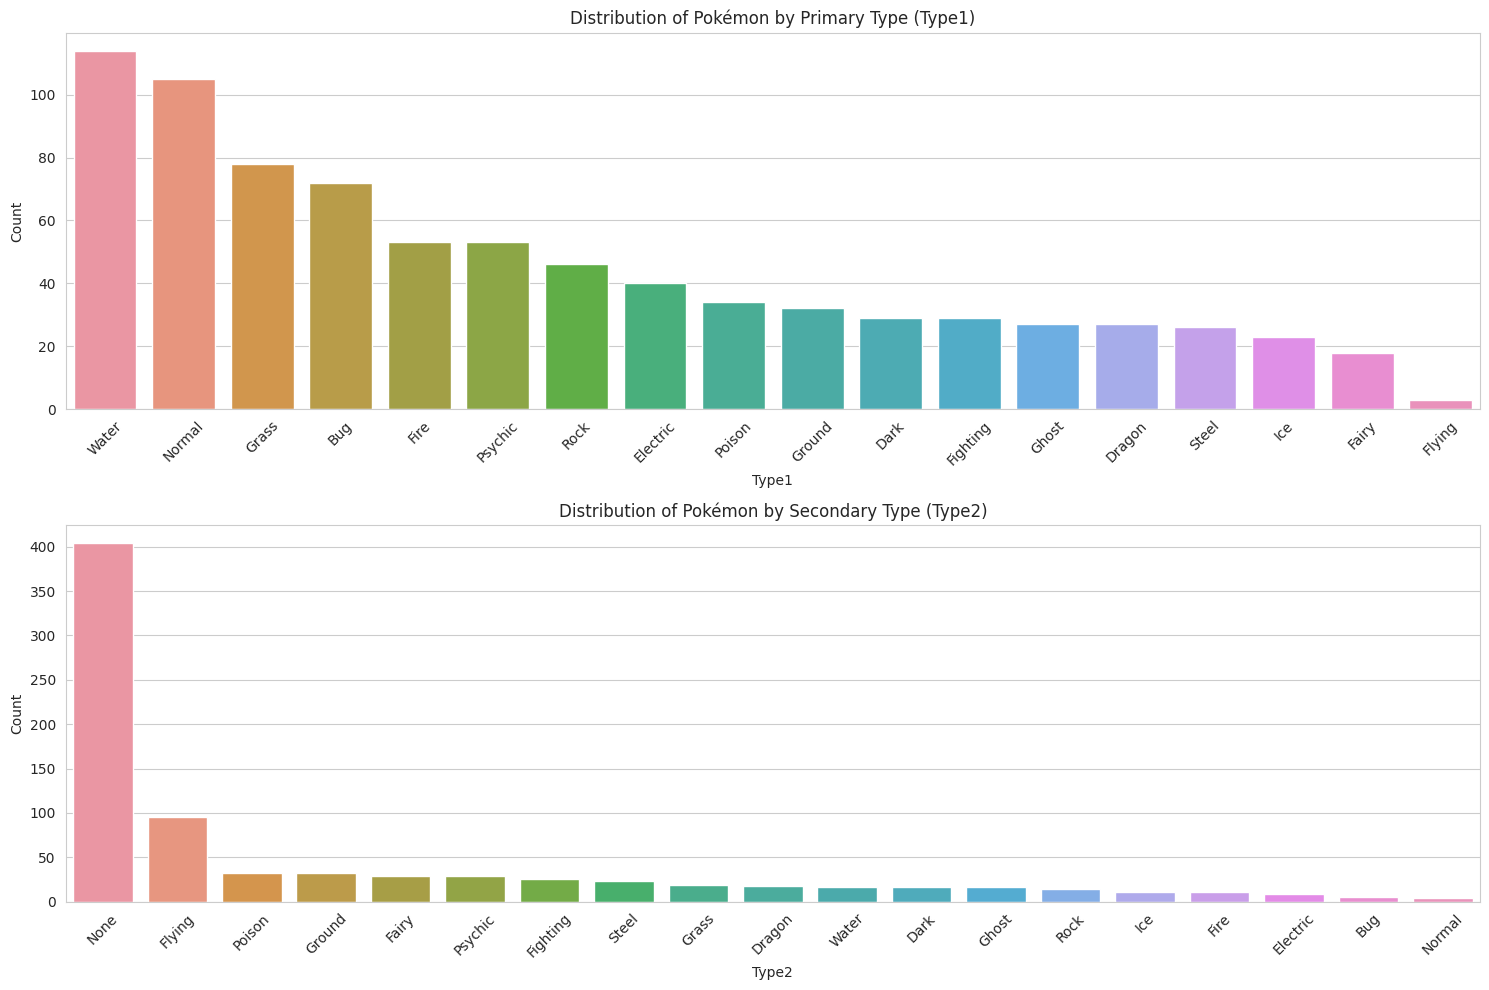

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for plots
sns.set_style("whitegrid")

# Plotting the distribution for Type1 and Type2
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(data=pokemon_df, x='Type1', order=pokemon_df['Type1'].value_counts().index, ax=ax[0])
ax[0].set_title('Distribution of Pokémon by Primary Type (Type1)')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=45)

sns.countplot(data=pokemon_df, x='Type2', order=pokemon_df['Type2'].value_counts().index, ax=ax[1])
ax[1].set_title('Distribution of Pokémon by Secondary Type (Type2)')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


The plots show the distribution of Pokémon based on their primary (Type1) and secondary (Type2) types. Here are some observations:

In the primary type (Type1), Water-type Pokémon appear to be the most common, followed by Normal and Grass types.

Many Pokémon do not have a secondary type (Type2), as indicated by the "None" category being the most prevalent.

Among those that do have a secondary type, Flying is the most common, followed by Poison.

Next, let's load and display a few images from the images folder to understand the visual aspect of the dataset.​

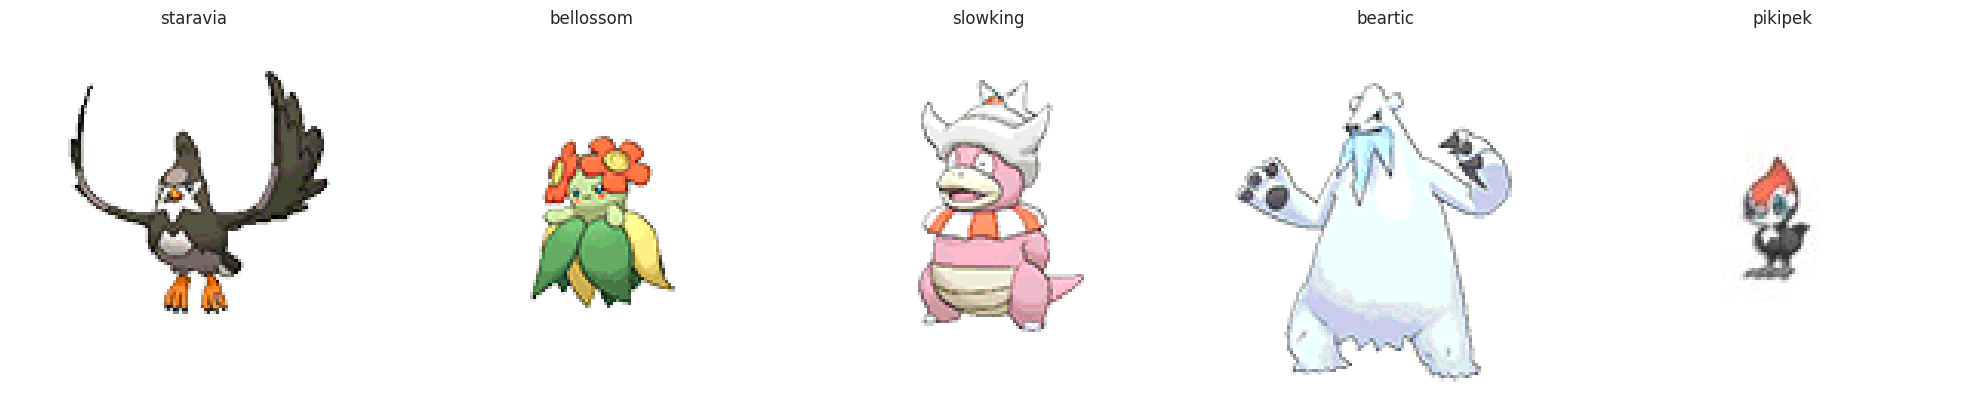

In [12]:
import random
from PIL import Image

image_folder='/content/drive/MyDrive/DM_Assignment_05/image-dataset(pokemon)/image-dataset(pokemon)/images'
# Update the image folder path to the nested "images" folder
nested_image_folder = os.path.join(image_folder, "images")

# Get the list of all image files from the nested folder
image_files_nested = [f for f in os.listdir(nested_image_folder) if os.path.isfile(os.path.join(nested_image_folder, f))]

# Randomly select a few image files
sample_images_nested = random.sample(image_files_nested, 5)

# Display the selected images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, image_file in zip(axes, sample_images_nested):
    img_path = os.path.join(nested_image_folder, image_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(image_file.split('.')[0])  # Show the name without the file extension
    ax.axis('off')

plt.tight_layout()
plt.show()


# Anomaly Detection

Data Preparation: Load the images, resize them to a consistent size, and normalize the pixel values.

Model Building: Design an autoencoder architecture.

Training: Train the autoencoder on the dataset.

Anomaly Detection: Use the trained autoencoder to reconstruct the images. Images with high reconstruction errors (based on a threshold) are potential anomalies.

Let's start with the Data Preparation step:

In [14]:
def load_and_preprocess_images_updated(image_folder, img_size):
    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    images = []

    for image_file in image_files:
        img_path = os.path.join(image_folder, image_file)
        img = Image.open(img_path).convert('RGB').resize(img_size)  # Ensure all images are RGB
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)

    return np.array(images)

# Load images again with the updated function
images_array_updated = load_and_preprocess_images_updated(nested_image_folder, img_size)

# Split the data into training and validation sets
train_images, val_images = train_test_split(images_array_updated, test_size=0.2, random_state=42)

train_images.shape, val_images.shape


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


((647, 64, 64, 3), (162, 64, 64, 3))

## Step 2: Model Building

Let's design an autoencoder architecture for the anomaly detection task. The autoencoder will consist of an encoder, which compresses the input image into a lower-dimensional latent representation, and a decoder, which reconstructs the image from the latent representation.​

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Build the autoencoder model
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Instantiate the autoencoder
autoencoder = build_autoencoder((64, 64, 3))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928 

# Building Auto Encoder

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

autoencoder = build_autoencoder((64, 64, 3))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Training Auto-Encoder

In [17]:
# Assuming train_images and val_images are already loaded and preprocessed
history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(val_images, val_images)
)


Epoch 1/50
21/21 [==============================] - 11s 453ms/step - loss: 0.4733 - val_loss: 0.1769
Epoch 2/50
21/21 [==============================] - 10s 463ms/step - loss: 0.1541 - val_loss: 0.1443
Epoch 3/50
21/21 [==============================] - 11s 514ms/step - loss: 0.1342 - val_loss: 0.1265
Epoch 4/50
21/21 [==============================] - 10s 473ms/step - loss: 0.1272 - val_loss: 0.1233
Epoch 5/50
21/21 [==============================] - 8s 389ms/step - loss: 0.1246 - val_loss: 0.1229
Epoch 6/50
21/21 [==============================] - 10s 485ms/step - loss: 0.1243 - val_loss: 0.1204
Epoch 7/50
21/21 [==============================] - 9s 453ms/step - loss: 0.1212 - val_loss: 0.1192
Epoch 8/50
21/21 [==============================] - 9s 416ms/step - loss: 0.1196 - val_loss: 0.1169
Epoch 9/50
21/21 [==============================] - 10s 484ms/step - loss: 0.1179 - val_loss: 0.1156
Epoch 10/50
21/21 [==============================] - 9s 454ms/step - loss: 0.1169 - val_loss: 

#3. Anomaly Detection
After training, you can use the trained autoencoder to reconstruct the images. Compute the reconstruction error (e.g., mean squared error) between the original and reconstructed images. Images with high reconstruction errors are potential anomalies.

In [18]:
# Predict the reconstructions
reconstructed_images = autoencoder.predict(val_images)

# Compute reconstruction error
mse = np.mean(np.square(val_images - reconstructed_images), axis=(1,2,3))

# Set a threshold for anomaly detection (e.g., a percentile or based on domain knowledge)
threshold = np.percentile(mse, 95)  # 95th percentile, you can adjust this

# Detect anomalies
anomalies = np.where(mse > threshold)[0]

print(f"Number of anomalies detected: {len(anomalies)}")


6/6 [==============================] - 1s 86ms/step
Number of anomalies detected: 9


## Anomaly elimination

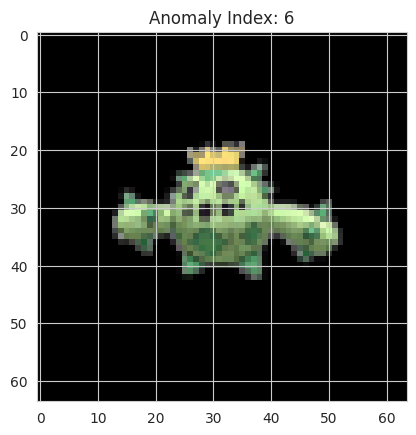

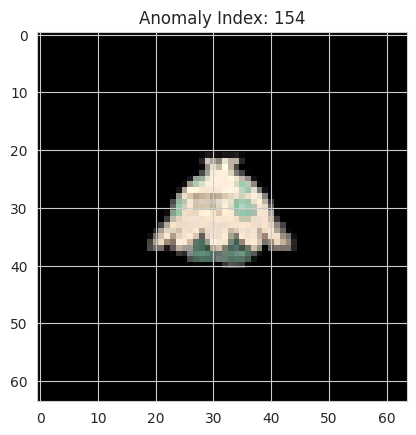

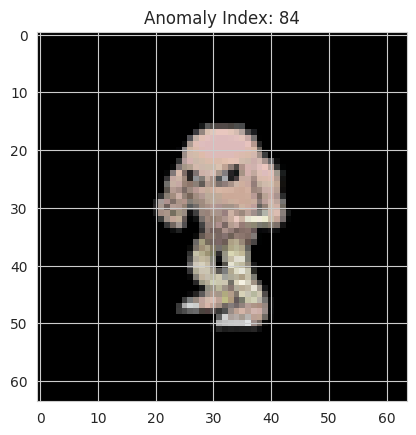

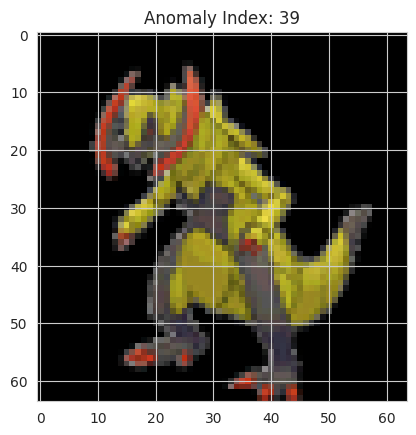

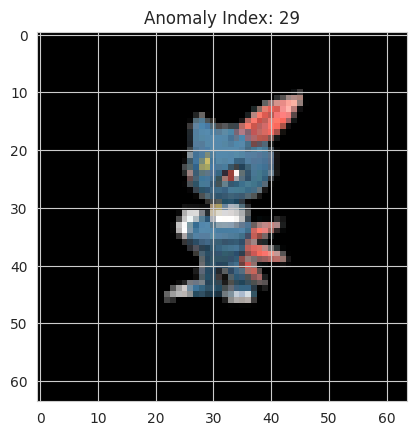

In [30]:
# Assuming `mse` is the mean squared error between the original and reconstructed images from the autoencoder
threshold = np.percentile(mse, 95)  # 95th percentile as the threshold
anomalies_indices = np.where(mse > threshold)[0]

# Visual Inspection (sample a few anomalies for visual confirmation)
sample_anomalies = np.random.choice(anomalies_indices, size=5, replace=False)
for index in sample_anomalies:
    plt.imshow(train_images[index])
    plt.title(f"Anomaly Index: {index}")
    plt.show()

# Removal
cleaned_train_images = np.delete(train_images, anomalies_indices, axis=0)


# Clustering using KMeans:
Determine Optimal Number of Clusters (k): The Elbow method can be used to determine the optimal number of clusters by fitting the KMeans algorithm to the data for a range of values of
k and then plotting the Total Within-Cluster Sum of Square (WSS) against the number of clusters. The "elbow" of the curve represents an optimal value for
k (a balance between precision and computational cost).


Apply KMeans Clustering: Once the optimal number of clusters is determined, KMeans can be applied to the data using that number of clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

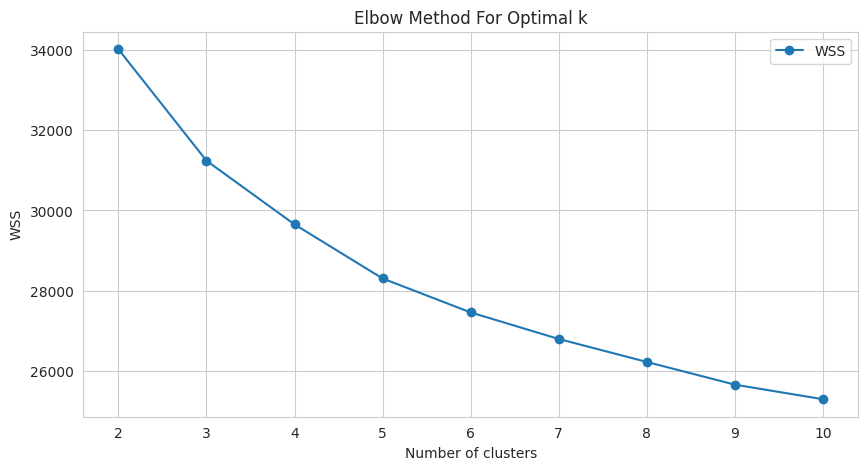

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the Elbow method and Silhouette Score
wss = []
sil_scores = []
max_clusters = 10
for i in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(train_features_pca)
    wss.append(kmeans.inertia_)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(train_features_pca, kmeans.labels_)
    sil_scores.append(silhouette_avg)

# Plot the Elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters+1), wss, marker='o', label='WSS')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.grid(True)
plt.show()




In [24]:
# Apply KMeans clustering using the optimal number of clusters (this can be inferred from the elbow plot)
optimal_clusters = 4  # You can adjust this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(train_features_pca)
cluster_distribution = np.bincount(clusters)

print("Cluster distribution:", cluster_distribution)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster distribution: [ 67  98 128 257  97]


In [25]:
from sklearn.manifold import TSNE

# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(train_features_pca)


### Visualising Clusters

<ipython-input-29-a456f68232be>:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=clusters, palette=palette, s=60, alpha=0.9, edgecolor=None)


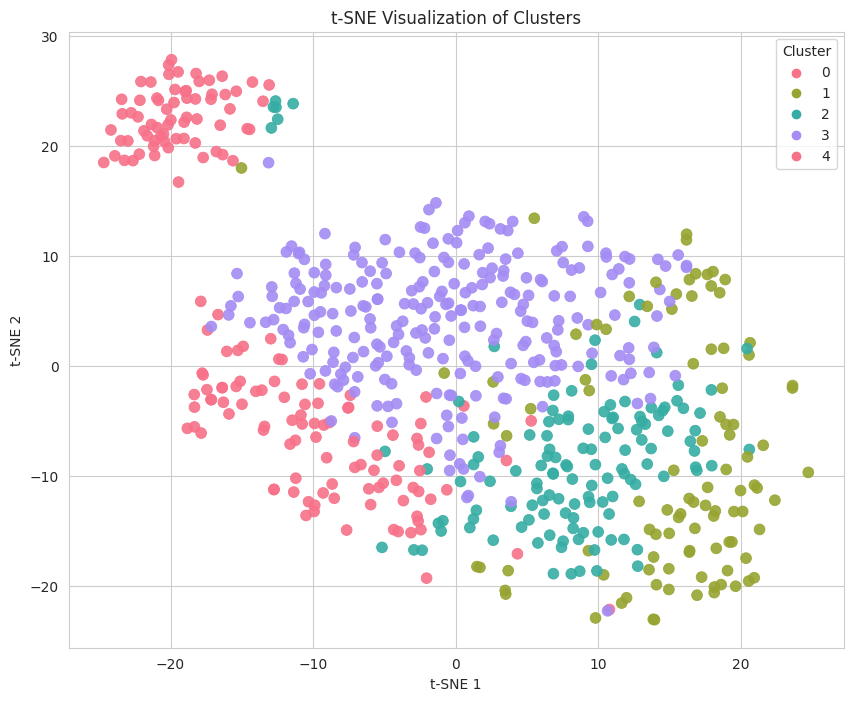

In [29]:
# Plot the 2D features and color by cluster assignments
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", 4)  # Assuming 4 clusters
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=clusters, palette=palette, s=60, alpha=0.9, edgecolor=None)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### 1. Feature Extraction using a Pre-trained Model:
We'll use the VGG16 model (trained on ImageNet) to extract features. The idea is to remove the top layers (fully connected layers) and use the remaining model as a fixed feature extractor.

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Extract features for train and validation sets
train_features = base_model.predict(train_images)
val_features = base_model.predict(val_images)

# Flatten extracted features
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)


6/6 [==============================] - 6s 942ms/step


### 2. Feature Selection using Dimensionality Reduction:
We'll use Principal Component Analysis (PCA) to reduce the feature dimensions while retaining the maximum variance in the data.

In [20]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)

print(f"Reduced feature dimensions (train): {train_features_pca.shape[1]}")
print(f"Reduced feature dimensions (val): {val_features_pca.shape[1]}")


Reduced feature dimensions (train): 150
Reduced feature dimensions (val): 150
